<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/Grid_Test_European_Call_1stock_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 10)
sigma_range = jnp.linspace(0.15, 0.45, 5)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(sigma_range)
print(r_range)

[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.15       0.225      0.3        0.37499997 0.45      ]
[0.01  0.025 0.04 ]


In [7]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 10)
sigma_range = jnp.linspace(0.15, 0.45, 5)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []

for S in S_range:
  for K in K_range:
    for r in r_range:
      for sigma in sigma_range:    

        initial_stocks = jnp.array([S]*numstocks) # must be float
        r_tmp = jnp.array([r]*numstocks)
        drift = r_tmp
        cov = jnp.identity(numstocks)*sigma*sigma

        European_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, T)
        Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, T)
        call.append([T, K, S, sigma, r, r, European_Call_price] + list(Deltas)) #T, K, S, sigma, mu, r, price, delta

Thedataset = pd.DataFrame(call)
Thedataset

,0,1,2,3,4,5,6,7
0,1.0,0.75,0.75,0.150,0.01,0.01,0.048458967,0.556185
1,1.0,0.75,0.75,0.225,0.01,0.01,0.07066231,0.562336
2,1.0,0.75,0.75,0.300,0.01,0.01,0.09278706,0.572583
3,1.0,0.75,0.75,0.375,0.01,0.01,0.114792734,0.584748
4,1.0,0.75,0.75,0.450,0.01,0.01,0.13664411,0.597456
...,...,...,...,...,...,...,...,...
1495,1.0,1.25,1.25,0.150,0.04,0.04,0.10037121,0.633561
1496,1.0,1.25,1.25,0.225,0.04,0.04,0.13602732,0.613980
1497,1.0,1.25,1.25,0.300,0.04,0.04,0.17195362,0.611451
1498,1.0,1.25,1.25,0.375,0.04,0.04,0.20784327,0.615662


In [8]:
# save to csv
Thedataset.to_csv('European_Call_1stock_MC_Datset.csv', index=False, header=False)

In [1]:
# read csv
import pandas as pd

Thedataset = pd.read_csv('European_Call_1stock_MC_Datset.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7
0,1.0,0.75,0.75,0.150,0.01,0.01,0.048459,0.556185
1,1.0,0.75,0.75,0.225,0.01,0.01,0.070662,0.562336
2,1.0,0.75,0.75,0.300,0.01,0.01,0.092787,0.572583
3,1.0,0.75,0.75,0.375,0.01,0.01,0.114793,0.584748
4,1.0,0.75,0.75,0.450,0.01,0.01,0.136644,0.597456
...,...,...,...,...,...,...,...,...
1495,1.0,1.25,1.25,0.150,0.04,0.04,0.100371,0.633561
1496,1.0,1.25,1.25,0.225,0.04,0.04,0.136027,0.613980
1497,1.0,1.25,1.25,0.300,0.04,0.04,0.171954,0.611451
1498,1.0,1.25,1.25,0.375,0.04,0.04,0.207843,0.615662


# Construct Neural Net

In [3]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:6]
Thedataset_Y = Thedataset.iloc[:,6:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
ds = OptionDataSet(max_len = 1)
for i in ds:
    print(i[0])
    print(i[0].shape)
    print(i[1])
    print(i[1].shape)

tensor([[1.000000, 0.750000, 0.750000, 0.150000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.750000, 0.225000, 0.010000, 0.010000],
        [1.000000, 0.750000, 0.750000, 0.300000, 0.010000, 0.010000],
        ...,
        [1.000000, 1.250000, 1.250000, 0.300000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.250000, 0.375000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.250000, 0.450000, 0.040000, 0.040000]],
       device='cuda:0', dtype=torch.float64)
torch.Size([1500, 6])
tensor([[0.048459, 0.556185],
        [0.070662, 0.562336],
        [0.092787, 0.572583],
        ...,
        [0.171954, 0.611451],
        [0.207843, 0.615662],
        [0.243560, 0.623065]], device='cuda:0', dtype=torch.float64)
torch.Size([1500, 2])


In [4]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, 32) # remember to change this!
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 16.0 MB/s 


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)
    # print(y_pred)
    # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.22479218252591118 average time 1.3788690109500066 iter num 20
loss 0.20514983342853016 average time 1.3789117804500166 iter num 40
loss 0.1956636757770327 average time 1.376099280566685 iter num 60
loss 0.19155502363259708 average time 1.3739592146500144 iter num 80
loss 0.19067695121594255 average time 1.3750027831000102 iter num 100
loss 0.1738297573680897 average time 1.3734450604000017 iter num 20
loss 0.159275652410698 average time 1.3718154431000074 iter num 40
loss 0.14922448499186183 average time 1.3735697645333327 iter num 60
loss 0.1443952883937085 average time 1.3748210943124917 iter num 80
loss 0.14335149262040922 average time 1.3759926464199952 iter num 100
loss 0.12269071761826862 average time 1.3966210240500119 iter num 20
loss 0.10299902940746218 average time 1.3876202032249865 iter num 40
loss 0.08955682458407643 average time 1.3830835429666613 iter num 60
loss 0.08353373766685383 average time 1.3830959378500012 iter num 80
loss 0.08229322794343581 average time 

In [ ]:
# 15:08
# 18:55

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_european_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

**Continue to train model**

In [18]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x.float())

    def compute_deltas(x):
      inputs = x.float()
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

model_save_name = 'jax_european_1stock_MC_oneDS_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.00013652123916828787 average time 1.3681041822499538 iter num 20
loss 0.0001284193753555044 average time 1.3715417652500945 iter num 40
loss 0.00012822533391631142 average time 1.3728060930668107 iter num 60
loss 0.0001276600512397113 average time 1.379346668612584 iter num 80
loss 0.00012755363931269992 average time 1.3769123472000502 iter num 100
loss 0.00012708040716049584 average time 1.3697410843001308 iter num 20
loss 0.00012675025065587617 average time 1.3681870665500355 iter num 40
loss 0.00012658012972776038 average time 1.3663464174000788 iter num 60
loss 0.000126492464314464 average time 1.3633718126875465 iter num 80
loss 0.0001264736933783537 average time 1.3631075895100184 iter num 100
loss 0.00012613121223107064 average time 1.3653008829002828 iter num 20
loss 0.00012583458328000233 average time 1.3631229919002634 iter num 40
loss 0.0001256403371949046 average time 1.3623458272668358 iter num 60
loss 0.00012555022639013533 average time 1.36354067697514 iter num 80

In [ ]:
# 18:58
# 22:46

#Results

In [19]:
import torch
inputs = torch.tensor([[1, 1, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.10870558, 0.581213937)

price: tensor([[0.108669]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([0.584903], device='cuda:0')

In [10]:
import cupy
import numpy as np
from torch.utils.dlpack import from_dlpack
from scipy.stats import norm
from math import log, sqrt, pi, exp
import pandas as pd

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))

print(bs_call(1,1,1,0.02,0.25))
print(bs_delta(1,1,1,0.02,0.25))

0.10870558490557591
0.5812139374874482


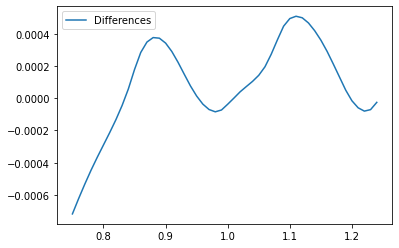

In [20]:
from scipy.stats import norm
from math import log, sqrt, pi, exp
import matplotlib.pyplot as plt
import numpy as np

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)    
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def compute_price(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
BS_call_prices = []
for p in prices:
    model_call_prices.append(compute_price(p).item())
    BS_call_prices.append(bs_call(p, 1, 1, 0.02, 0.25))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, BS_call_prices, label = "BS_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(BS_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

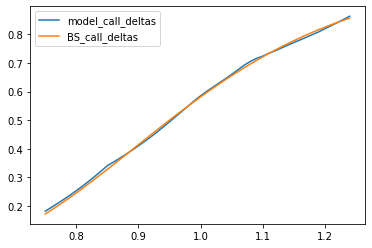

In [21]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

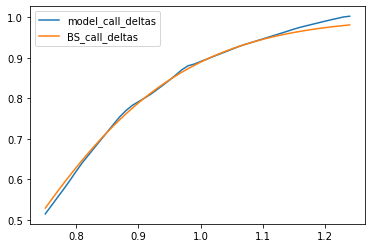

In [22]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 0.775, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()

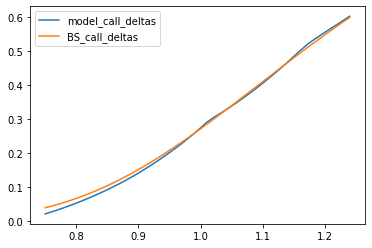

In [23]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, S, 0.25, 0.02, 0.02]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

def bs_delta(S,K,T,r,sigma):
  return norm.cdf(d1(S,K,T,r,sigma))

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
BS_call_deltas = []
for p in prices:
    model_call_deltas.append(compute_delta(p).item())
    BS_call_deltas.append(bs_delta(p, 1.225, 1, 0.02, 0.25))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, BS_call_deltas, label = "BS_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(BS_call_deltas), label = "Differences")
plt.legend()
plt.show()